In [1]:
import math
import numpy as np
import cmath 

import matplotlib.pyplot as plt


import matplotlib.pyplot as plt
%matplotlib inline
params = {'legend.fontsize': 24,
          'figure.figsize': (15, 10),
         'axes.labelsize': 24,
         'axes.titlesize': 24,
         'xtick.labelsize':24,
         'ytick.labelsize':24}
plt.rcParams.update(params)

In [2]:
def getSpice(y):
    print( '.param g11= {0.real:6.4E}' .format(y[0,0]) )
    print( '.param g12= {0.real:6.4E}' .format(y[0,1]) )
    print( '.param g21= {0.real:6.4E}' .format(y[1,0]) )
    print( '.param g22= {0.real:6.4E}' .format(y[1,1]) )
    print( '.param c11= {0:6.4E}' .format(y[0,0].imag/(wo)) )
    print( '.param c12= {0:6.4E}' .format((y[0,1].imag)/(wo)) )
    print( '.param c21= {0:6.4E}' .format((y[1,0].imag)/(wo)) )
    print( '.param c22= {0:6.4E}' .format(y[1,1].imag/(wo)) )

def getComp(y):
    print( '.param gg= {0.real:6.4}' .format(y) )
    print( '.param cg= {0:6.4E}' .format((y.imag)/(wo)) )
    
    


In [24]:
def yin(y,ys):
    return y[0,0] - (y[0,1]*y[1,0])/(y[1,1]+ys)

def yout(y,ys):
    return y[1,1] - (y[0,1]*y[1,0])/(y[0,0]+ys)

def ydw(y,wo,w):
    b = y.imag
    yw = y.real +1j*b*(w/wo)
    #if b < 0  : yw = y.real +1j*b*(wo/w)    
    #if b == 0 : yw = y.real
    return yw

def gbw(g,bc,bl,wo,w):
    y = (g + 1j * (bc*(w/wo) -bl*(wo/w)))
    return y
    
def ycdw(y,wo,w):
    y11w = ydw(y[0,0],wo,w)
    y12w = ydw(y[0,1],wo,w)
    y21w = ydw(y[1,0],wo,w)
    y22w = ydw(y[1,1],wo,w)
    yt = np.matrix([[y11w, y12w],[ y21w, y22w]])
    return yt

def RLC(y,Qo,Qc,wo):    
    g  = y.real
    rext = (1/y.real)/2
    bl   = (1/Qc-1/Qo)*rext
    bc   =  bl
    if y.imag > 0 : bc = bc - abs(y.imag)
    if y.imag < 0 : bl = bl - abs(y.imag)
    gp  = 1/(bl*Qo)
    return (g,bc,bl,gp)


def divC(Q,wo,Rin,RL):
    Qm = ((RL/Rin)*(1+Q**2)-1)**0.5
    C  = Q/Rin/wo
    Cs = C*(1+1/Q**2)
    Cb = Qm/RL/wo
    Cbs = Cb*(1+1/Qm**2)
    Ca = 1/(1/Cs-1/Cbs)
    return(Ca,Cb)

In [49]:
Qo = 150

wo = 2*math.pi*100e6

Qa = 40
wa = wo
Qb = 40
wb = wo

fo = 100e6
wo = 2*np.pi*fo

y11 =   5.00e-3 + 1.50e-3*1j
y12 = - 0.012e-3 - 0.02e-3*1j
y21 =   5.50e-3 - 0.38e-3*1j 
y22 =   0.04e-3 + 0.70e-3*1j


ytr = np.matrix([[y11, y12],[ y21, y22]])

getSpice(ytr)


.param g11= 5.0000E-03
.param g12= -1.2000E-05
.param g21= 5.5000E-03
.param g22= 4.0000E-05
.param c11= 2.3873E-12
.param c12= -3.1831E-14
.param c21= -6.0479E-13
.param c22= 1.1141E-12


In [57]:
yga  = ytr[0,0].real - 1j* ytr[0,0].imag
# yg evaluado en wb
ygb  = ydw(yga,wa,wb)
for n in range(5):
    # el transistor evaluado en wb
    ytrb = ycdw(ytr,wo,wb)
    # salida del transistor en wb
    yob  = yout(ytrb,ygb)
    # Calculo los componentes
    (gb,bcb,blb,gpb) = RLC(yob,Qo,Qb,wb)
    # la carga que sintonia la salida
    ylb = gb + gpb + 1j *(bcb - blb)
    # la admitancia de la salida evaluada en wa
    yla  = gbw(gb+gpb,bcb,blb,wb,wa)
    # el transistor evaluado en wa
    ytra = ycdw(ytr,wo,wa)
    # entrada del transistor en wa
    yia  = yin(ytra,yla)
    # Calculo los componentes
    (ga,bca,bla,gpa) = RLC(yia,Qo,Qa,wa)
    # la carga que sintonia la salida
    yga = ga + gpa + 1j *(bca - bla)
    # yg evaluado en wb
    ygb  = gbw(ga+gpa,bca,bla,wa,wb)  
    #print(1/yia.real, yia.imag/wa)
    #print(1/yob.real, yob.imag/wb)
    
print(yia)
print(yob)
    
    
print(1/yia.real, yia.imag/wa)
print(1/yob.real, yob.imag/wb)
    

Q = (1/Qb-1/Qo)**(-1)
print(1/gb)

(C1,C2) = divC(Q*2,wa,1/gb,50)
(C3,C4) = divC(Q*2,wb,1/gb,50)    
print(1/ga,1/gb)
n = (ga/gb)**0.5
ls = 1/(blb*wb)
l1 = ls/n**2
l2 = ls*((n-1)/n)**2

print(n,ls,l1,l2)
print( '.param rg= {0:6.4E}'     .format(50) )
print( '.param c1= {0:6.4E}'     .format(C1) )
print( '.param c2= {0:6.4E}'     .format(C2) )
print( '.param l1= {0:6.4E}'     .format(l1 ))    
print( '.param l2= {0:6.4E}'     .format(l2 ) )   
print( '.param rgp= {0:6.4E}'     .format(1/gpb) )


print( '.param rl= {0:6.4E}'     .format(50) )
print( '.param c3= {0:6.4E}'     .format(C3) )
print( '.param c4= {0:6.4E}'     .format(C4) )

print( '.param ll= {0:6.4E}'     .format(1/(blb*wb)) )    
print( '.param rlp= {0:6.4E}'     .format(1/gpb) )
print(C3/1e-12,C4/1e-12)


yli  = gbw(gb+gpb,bcb,blb,wb,wo)
#ytri = ycdw(ytr,wo,wo)
ygi  = gbw(ga+gpa,bca,bla,wa,wo)
yia  = yin(ytr,yli) + ygi
    


print( '|yia|= {0:6.4E}, <yio= {1:6.1F}' .format(abs(1/yia), cmath.phase(1/yia)*180./np.pi) )

(0.00556911072233+0.00243806077535j)
(4.45528858582e-05+0.000707504486268j)
179.561881575 3.88029423955e-12
22445.2351568 1.12602836249e-12
22445.2351568
179.561881575 22445.2351568
11.1803398775 7.73543128728e-12 6.18834504087e-14 6.41355872096e-12
.param rg= 5.0000E+01
.param c1= 8.1117E-12
.param c2= 1.6078E-10
.param l1= 6.1883E-14
.param l2= 6.4136E-12
.param rgp= 3.0862E+04
.param rl= 5.0000E+01
.param c3= 8.1117E-12
.param c4= 1.6078E-10
.param ll= 7.7354E-12
.param rlp= 3.0862E+04
8.11166114939 160.779693411
|yia|= 6.5839E+01, <yio=    0.0


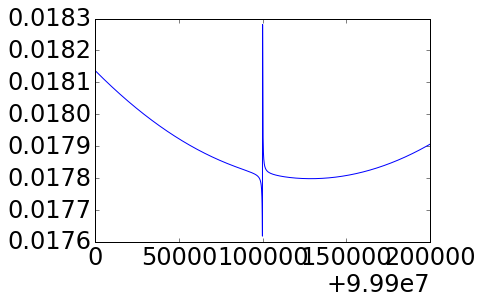

In [41]:
f  = np.arange(99.9e6,100.1e6,1e2)
w  = 2*math.pi*f
ym = list()
for wi in w:
    yli  = gbw(gb+gpb,bcb,blb,wb,wi)
    ytri = ycdw(ytr,wo,wi)
    ygi  = gbw(ga+gpa,bca,bla,wa,wi)
    yia  = yin(ytri,yli) + ygi
    
    
    ym.append(yia)
plt.plot(f, [abs(y) for y in ym])
    
plt.show()

In [23]:
ygb  = ydw(yg,wo,wb)
ytrb = ycdw(ytr,wo,wb)
yob  = yout(ytrb,ygb)
(gb,bcb,blb,gpb) = RLC(yob,Qo,Qc,wb)

print( '.param rl= {0:6.4E}'     .format(1/gb) )
print( '.param cl= {0:6.4E}'     .format(bcb/wb) )
print( '.param ll= {0:6.4E}'     .format(1/(blb*wb)) )    
print( '.param rp= {0:6.4E}'     .format(1/gpb) )


ylb = gb + gpb + 1j *(bcb - blb)
yla  = ydw(ylb,wb,wa)
ytra = ycdw(ytr,wo,wa)
yia  = yin(ytra,yla)


print( '|yia|= {0:6.4E}, <yio= {1:6.1F}' .format(abs(yia), cmath.phase(yia)*180./np.pi) )

NameError: name 'yg' is not defined

In [67]:
Q = 1/(1/Qa - 1/Qo)
r = 12e3
rext = r/2

L = ( (rext/Q)/wo )
C = 1/(wo**2*L)
n = (r/50)**0.5
C1 = C *n/(n-1)
C2 = C * n

In [70]:
print(C1/1e-12,C2/1e-12,L/1e-9)

15.467023247737117 224.14707056781813 175.0704374010849
